# CogPonder: Stroop task with fixed hyper-parameters

This notebook implements the CogPonder framework using PyTorch Lightning and evaluate it on the Stroop task.


It assumes fixed hyper-parameters and fits the model to a single-subject dataset. It wraps a simple linear network with a pondering layer and trains it on the *Self-Regulation Ontology* dataset.


## Data

Here, we fit the Stroop data from the *Self-Regulation Ontology*. The data is loaded from the `data/Self_Regulation_ontology/` directory; see the [README](../data/Self_Regulation_Ontology/README.md) for more information on the data structure.

### Input and Output


The input contains a list of trials, each includes 1) the color and 2) the letter of the current stimulus. The output is the human response to the current trial (i.e., red, green, or blue).


## Hyper-parameters

- `n_embeddings`: number of hidden units in the operator model. Defaults to 2.
- `resp_loss_beta`: the beta parameter of the loss function. Defaults to 1.
- `time_loss_beta`: the beta parameter of the loss function. Defaults to 0.5.
- `learning_rate`: the learning rate of the optimizer. Defaults to 0.0001.
- `max_response_step`: maximum response step in the dataset. Defaults to 100.

## Criterion

The loss function is a weighted sum of the response loss regularized by the response time loss. The regularizer weight is controlled by the `time_loss_beta` hyper-parameter.

$L = L_{\text{response}} + \beta L_{\text{time}}$


In [7]:
%reload_ext autoreload
%autoreload 3

from IPython.display import display

import torch
import torchmetrics
import pytorch_lightning as pl
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBar
from src.cogponder import CogPonderModel
from src.cogponder.datasets import StroopSRODataset, CogPonderDataModule

In [22]:
# Load the dataset and configs

print('Loading Stroop dataset... ', end='')

SUBJECT_INDEX = 202
data = StroopSRODataset(n_subjects=-1, response_step_interval=10)[SUBJECT_INDEX]

# parameter space
CONFIG = {
    'task': 'stroop',
    'checkpoint_path': 'models/stroop/fixed_hp_s202.ckpt',
    'resp_loss_beta': 1.,
    'time_loss_beta': 4.,
    'non_decision_time': 10,  # in milliseconds
    'loss_by_trial_type': False,
    'learning_rate': 1e-2,
    'max_response_step': data[4].max() + 1,
    'inputs_dim': data[0].size(1) - 1,
    'embeddings_dim': 2,
    'outputs_dim': torch.unique(data[3]).size(0),  # number of unique responses
    'auto_lr_find': False,
    'batch_size': 196,
    'n_subjects': 1,
}

datamodule = CogPonderDataModule(data,
                                 batch_size=CONFIG['batch_size'],
                                 num_workers=8)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Done!')

Loading Stroop dataset... Done!


In [ ]:
# Define the pondering model and run the trainer

model = CogPonderModel(CONFIG)#, example_input_array=data[0][:1].to(device))

# Trainer
trainer = pl.Trainer(
    max_epochs=100,
    # min_epochs=100,
    accelerator='auto',
    auto_lr_find=CONFIG['auto_lr_find'],
    log_every_n_steps=1,
    # overfit_batches=True,
    # accumulate_grad_batches=2,
    callbacks=[
        RichProgressBar(),
        EarlyStopping(monitor='val/total_loss', patience=1000, mode='min', min_delta=0.001),
    ])

# Auto-detect learning-rate if the flag is set
if CONFIG['auto_lr_find']:
    trainer.tune(model, datamodule=datamodule)

# Fit ans evaluate the model
trainer.fit(model, datamodule=datamodule)

# Save the checkpoint
trainer.save_checkpoint(CONFIG['checkpoint_path'])

In [ ]:
# DEBUG

# DEBUG - Load the checkpoint

model_ckpt = CogPonderModel.load_from_checkpoint(CONFIG['checkpoint_path'])
model_ckpt.eval()

if not 'datamodule' in locals() or not hasattr(datamodule, 'train_dataset'):
    print('loading data module...')
    datamodule = CogPonderDataModule(data, batch_size=CONFIG['batch_size'], num_workers=8)
    datamodule.prepare_data()

X_train, trial_types_train, _, y_train, rt_train = datamodule.dataset[datamodule.train_dataset.indices]
X_test, trial_types_test, _, y_test, rt_test = datamodule.dataset[datamodule.test_dataset.indices]

with torch.no_grad():
    model_ckpt.eval()

    y_train_steps,_,rt_train_pred = model_ckpt(X_train)
    y_test_steps,_,rt_test_pred = model_ckpt(X_test)
    
    y_train_steps = torch.argmax(y_train_steps, dim=-1)
    y_test_steps = torch.argmax(y_test_steps, dim=-1)

    y_train_pred = y_train_steps.gather(dim=0, index=rt_train_pred[None, :] - 1,)[0]  # (batch_size,)
    y_test_pred = y_test_steps.gather(dim=0, index=rt_test_pred[None, :] - 1,)[0]  # (batch_size,)

    train_res = pd.DataFrame({'true_rt_train': rt_train.detach().tolist(),
                              'pred_rt_train': rt_train_pred.tolist()})
    test_res = pd.DataFrame({'true_rt_test': rt_test.detach().tolist(),
                             'pred_rt_test': rt_test_pred.tolist()})

    display(train_res.T, test_res.T)

    # report accuracy
    match CONFIG['task']:
        case 'nback':
            accuracy_fn = torchmetrics.Accuracy().to(device)
            train_accuracy = accuracy_fn(y_train_pred, y_train.int())
            print('NBACK TRAIN ACCURACY', train_accuracy.item())
            accuracy_fn = torchmetrics.Accuracy().to(device)
            test_accuracy = accuracy_fn(y_test_pred, y_test.int())
            print('NBACK TEST  ACCURACY', test_accuracy.item())
        case 'stroop':
            pass

# DEBUG report medians
print(f'RT train mean (pred/true): {rt_train_pred.float().mean().item():.2f}, {rt_train.float().mean().item():.2f}')
print(f'RT test  mean (pred/true): {rt_test_pred.float().mean().item():.2f}, {rt_test.float().mean().item():.2f}')


In [30]:
# prepare plotting data

plot_data_train = pd.DataFrame({
    'rt': rt_train,
    'trial_type': trial_types_train,
    'color': X_train[:, 0],
    'word': X_train[:, 1],
    'data': 'truth',
    'split': 'train',
})

plot_data_train_pred = pd.DataFrame({
    'rt': rt_train_pred,
    'trial_type': trial_types_train,
    'color': X_train[:, 0],
    'word': X_train[:, 1],
    'data': 'pred',
    'split': 'train',
})

plot_data_test = pd.DataFrame({
    'rt': rt_test,
    'trial_type': trial_types_test,
    'color': X_test[:, 0],
    'word': X_test[:, 1],
    'data': 'truth',
    'split': 'test',
})

plot_data_test_pred = pd.DataFrame({
    'rt': rt_test_pred,
    'trial_type': trial_types_test,
    'color': X_test[:, 0],
    'word': X_test[:, 1],
    'data': 'pred',
    'split': 'test',
})

# merge and cleanup
plot_data = pd.concat([plot_data_train, plot_data_train_pred, plot_data_test, plot_data_test_pred])
plot_data['trial_type'] = plot_data['trial_type'].map({0: 'incongruent', 1: 'congruent'})

max_rt = CONFIG["max_response_step"].item()

plot_data = plot_data.query('rt < @max_rt')

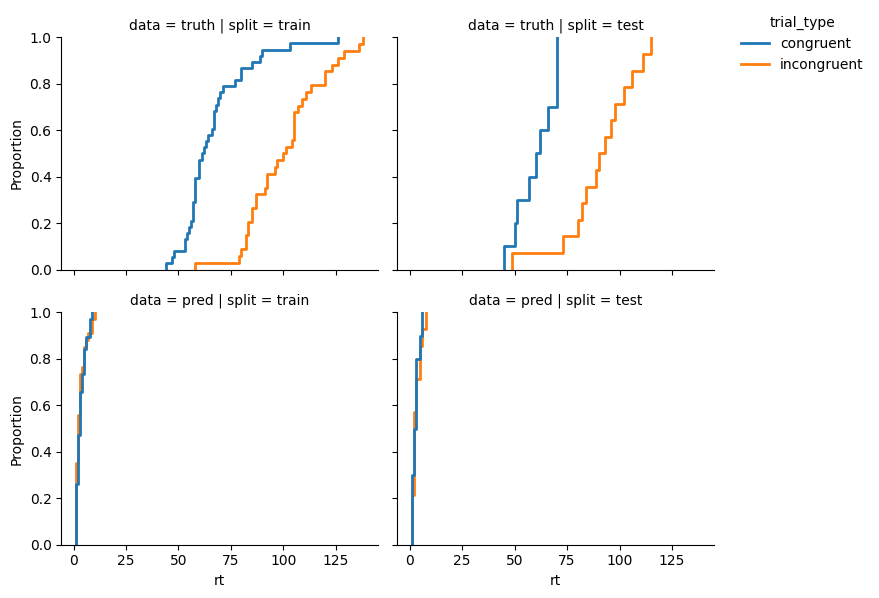

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.displot(
    plot_data,
    x='rt', row='data', col='split', hue='trial_type',
    kind='ecdf', linewidth=2, height=3,
)

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))



# plt.title(f'Evaluation profile of CogPonder on train split (Stroop)')

plt.tight_layout()
plt.show()


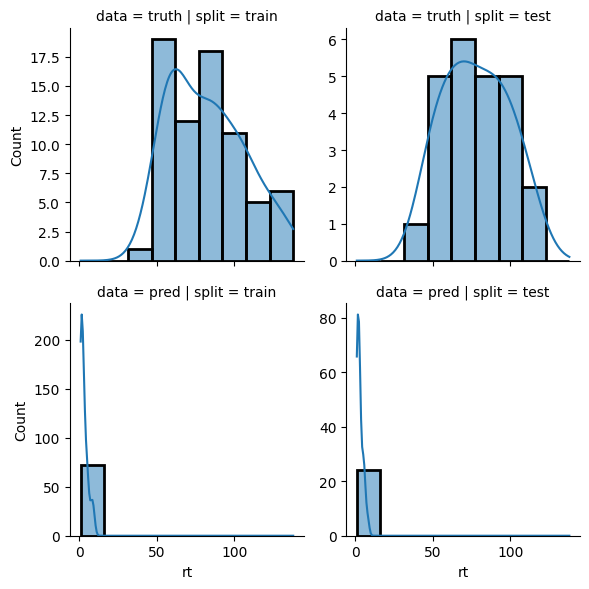

In [40]:
g = sns.displot(
    plot_data.reset_index(),
    x='rt', row='data', col='split', #hue='trial_type',
    kind='hist', linewidth=2, height=3, #palette='Greens',
    kde=True, kde_kws={'clip': (0, max_rt)},
    facet_kws={'sharey': False}
)
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


# plt.title(f'Evaluation profile of CogPonder on train split (Stroop)')

plt.tight_layout()
plt.show()
